# SIMPLE FLOWER CLASSIFIER MIT ADALINE

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Unterschied zu Perzeptron:
- Im Gegensatz zur Perzeptron-Regel beruht bei Adaline die Berechnung der Gewichtungsaktualisierung auf allen in der Trainingsdatenmenge enthaltenen Objekten.

## ADALINE - ADAPTIVE LINEAR NEURON

In [28]:
class AdalineGD(object):

    def __init__(self, eta=0.01, n_iter=10):
        # eta: Lernrate 0 <= eta <= 1
        # n_iter: Anzahl Korrekturen am Modell (Epochen)
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        # Erstelle Modell aus
        # X = Alle Merkmalsausprägungen
        # y = Korrekte Klassen (-1, 1) der Merkmalsausprägungen
        self.w_ = np.zeros(1 + X.shape[1]) # Gewichtsvektor w_ (3 Gewichte)
        self.cost_ = [] # Summe der quadratischen Abweichungen

        for i in range(self.n_iter):
            output = self.net_input(X) # Summe aus Gewichtvektor und Merkmalsausprägungsvektor
            errors = (y - output) # Abweichungen vom Soll-Wert
            self.w_[1:] += self.eta * X.T.dot(errors) # Berechnung des Gradienten für w1-m
            self.w_[0] += self.eta * errors.sum() # Berechnung des Gradienten für w0
            cost = (errors**2).sum() / 2.0 # Berechnung der Straffunktion
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        # Übertragungsfunktion: Summe aus Gewichtsvektor w_ und Merkmalsausprägungsvektor X (Skalarprodukt)
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        # Lineare Aktivierungsfunktion berechnen
        return self.net_input(X)

    def predict(self, X):
        # Rückgabe der Klasse durch Aufruf der Aktivierungsfunktion
        # ansonsten Aktivierungsfunktion = -1
        return np.where(self.activation(X) >= 0.0, 1, -1)

## PLOT ENTSCHEIDUNGSGRENZE

In [15]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # Plotten der Entscheidungsgrenze
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plotten aller Objekte
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, label=cl)

## DATENSET LADEN

In [16]:
# Load/Print Dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
print(df.tail())

       0    1    2    3               4
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica


## DATEN VORBEREITUNG FÜR ADALINE

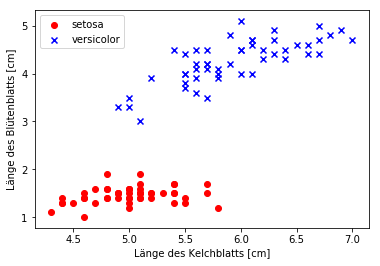

In [17]:
y = df.iloc[0:100, 4].values # Teile Datenset (erste 100 Werte) und erhalte 4. Spalte (Klasse)
y = np.where(y == 'Iris-setosa', -1, 1) # Setze Iris-setosa als Klasse -1 fest, alle anderen als 1
X = df.iloc[0:100, [0, 2]].values # Nehme erste 100 Merkmalsausprägungen
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa') # setosa ist in den ersten 50 datensätzen
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor') # versicolor ist in den zweiten 50 datensätzen
plt.xlabel('Länge des Kelchblatts [cm]')
plt.ylabel('Länge des Blütenblatts [cm]')
plt.legend(loc='upper left')
plt.show() # Zeige Diagramm

## ADALINE MODELL ERSTELLEN UND MODELL LERNEN LASSEN

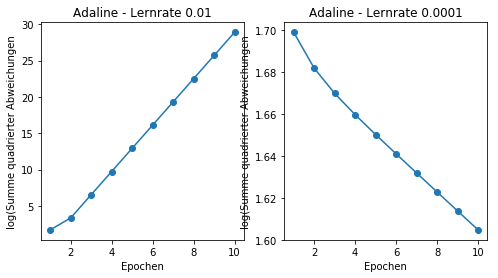

In [18]:
# Zwei verschiedene Adaline Modelle mit unterschiedlichen Lernraten (0.01 vs. 0.0001)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochen')
ax[0].set_ylabel('log(Summe quadrierter Abweichungen')
ax[0].set_title('Adaline - Lernrate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochen')
ax[1].set_ylabel('log(Summe quadrierter Abweichungen')
ax[1].set_title('Adaline - Lernrate 0.0001')

plt.show()

### Beschreibung des Outputs:
- Links: Lernrate zu groß gewählt, da Summe der Fehlerwerte immer größer wird
- Rechts: Lernrate sehr klein; Werte sinken zwar, aber Modell würde sehr lange brauchen um zu konvergieren

Deshalb: Die Werte müssen vorerst standardisiert werden (z-Wert), damit Gradient mit Lernrate von 0.01 gefunden werden kann

## EINGABEDATEN STANDARDISIEREN UND ENTSCHEIDUNGSGRENZE DES MODELLS PLOTTEN

In [19]:
# Standardisierung mithilfe des z-Wertes (x_i - x_mean) / std
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

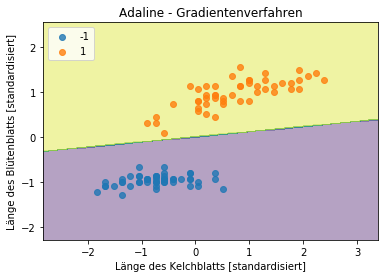

In [29]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradientenverfahren')
plt.xlabel('Länge des Kelchblatts [standardisiert]')
plt.ylabel('Länge des Blütenblatts [standardisiert]')
plt.legend(loc='upper left')
plt.show()

## MODELL-FEHLER ÜBER EPOCHEN

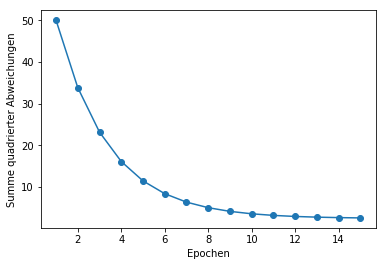

In [21]:
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochen')
plt.ylabel('Summe quadrierter Abweichungen')
plt.show()

## KLASSE VORHERSAGEN NACHDEM MODELL ANGELERNT WURDE

In [22]:
print(ada.predict([6, 3]))

1
